## Modelo SEIR para epidemias

Rodrigo Fritz

Los datos necesarios para modelar una epidemia son los siguientes:

$R_0$ es el número básico de reproducción, que es el número de infecciones secundarias generadas a partir del primer caso al inicio de la epidemia en una población totalmente susceptible

En
https://royalsociety.org/-/media/policy/projects/set-c/set-covid-19-R-estimates.pdf
se menciona que

$R_0 = 2.5$ para COVID-19

$p = 1 - \dfrac{1}{R_0} = 0.6$ es la proporción crítica de la población que debe ser inmune para detener la transmisión

$R_0 = \dfrac{\beta}{\gamma}N$

$N$ es el tamaño de la población

$\beta$ es la tasa de transmisión dada por el producto del número total de contactos y la probabilidad de transmisión

$\gamma$ es la tasa de infecciosidad, que es el inverso de la duración promedio, esta duración es de 21 días para COVID-19

$\sigma$ es la tasa de incubación, que es el inverso del periodo de incubación, que es de 4 días para COVID-19

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd

La simulación con autómatas celulares, i.e. el modelo basado en agentes, genera una imagen para cada paso de la evolución, cada una de las cuales será guardada fuera de este notebook en un .gif

Los tipos de población para el modelo basado en agentes se definen a continuación:

In [33]:
#Los expuestos conforman el estado intermedio entre susceptibles e infectados

def exposed(df, σ=1/4): #σ = periodo de incubación de 4 días para covid
    susc = df[df["state"] < 2] #Susceptibles: estados 0 y 1
    infs = df[df["state"]== 2] #Infectados estado 2
    if(len(susc) == 0):
        return susc
    exps = np.random.choice(susc.index, 5*len(infs), replace=True)
    for i in exps:
        df.iloc[i]["state"] = 1 #Los Susceptibles se transforman en Expuestos: estado 1
    return exps

In [5]:
def infected(df, lst_cont, β=0.119): # β = tasa de transmisión = R_0·γ
    no_rep = np.unique(lst_cont)
    for c in no_rep:
        p = np.random.uniform(0,1)
        if(df.iloc[c]["state"]==1 and p<=β): #Los Susceptibles (estado 1) se transforman en 
            df.iloc[c]["state"]=2            #Infectados (estado 2) con tasa de transmisión beta

In [6]:
def removed(df, γ=1/21): #γ = periodo de recuperación de 21 días para covid
    for i in range(len(df)):
        p = np.random.uniform(0,1)
        if(df.iloc[i]["state"]==2 and p<=γ): #Los infectados se transforman en recuperados después de 1/gamma días
            df.iloc[i]["state"]=3

In [38]:
γ = 1/21  #tasa de recuperación (21 días)
β = 2.5*γ #tasa de transmisión (R_0·γ)
σ = 1/4   #tasa de incubación (4 días)
Tmax = 121
side = 20
nAgents = side**2
state = np.zeros(nAgents,dtype=int)
data = {"state": state}
agents = pd.DataFrame(data)

#Iniciar un infectado en una posición aleatoria
i0 = np.random.randint(0,nAgents)
agents.iloc[i0]["state"] = 2
S = [len(agents[agents["state"]==0])]
E = [0]
I = [len(agents[agents["state"]==2])]
R = [0]

#Autómatas Celulares
cmap = colors.ListedColormap(['blue','orange','green','red']) #Para tener el mismo código de color que el default de pyplot
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)
for t in range(Tmax):
    exps = exposed(agents,σ)
    infected(agents,exps,β)
    removed(agents,γ)
    sts = np.array(agents["state"])
    show_sts = np.reshape(sts,(side,side))
    img = plt.imshow(show_sts,cmap=cmap,norm=norm)
    plt.colorbar(boundaries=bounds, ticks=[0,1,2,3])
    plt.title("t = "+str(t))
    name = "./img"+str(t).zfill(3)+".png"
    plt.savefig(name)
    plt.clf()
    S.append(len(agents[agents["state"]==0]))
    E.append(len(agents[agents["state"]==1]))
    I.append(len(agents[agents["state"]==2]))
    R.append(len(agents[agents["state"]==3]))

<Figure size 432x288 with 0 Axes>

In [29]:
agents.describe() #Al final de la simulación casi todos están en el estado 3: removidos

,state
count,400.000000
mean,2.812500
std,0.390801
min,2.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,3.000000


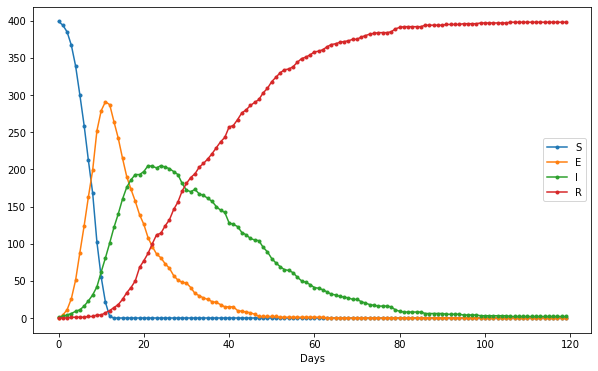

In [27]:
plt.figure(figsize=(10,6))
plt.plot(S, '.-', label="S")
plt.plot(E, '.-', label="E")
plt.plot(I, '.-', label="I")
plt.plot(R, '.-', label="R")
plt.xlabel('Days')
plt.legend()
plt.show()

El archivo .gif compilado se ve así:

<img src="gif.gif">

donde el código de color es el mismo que el de la gráfica: azul = susceptible, naranja = expuesto, verde = infectado, rojo = removido